# Load Data

In [1]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
# %matplotlib inline

In [55]:
reg_result =pd.read_csv('result/regression/dbp/test_result.csv', header=None, sep=' ')
sbp_result = pd.read_csv('result/regression/sbp/test_result.csv', header=None, sep=' ')
init_value = pd.read_csv('result/regression/test_init_value.csv')
reg_result.rename(columns={0: 'dbp_pred', 1: 'dbp_target'}, inplace=True)

reg_result[['sbp_pred','sbp_target']] = sbp_result
reg_result['VS_sbp_init'] = init_value['VS_sbp_init']
reg_result['VS_dbp_init'] = init_value['VS_dbp_init']

In [56]:
reg_result['relative_dbp_pred'] = reg_result['dbp_pred'] - reg_result['VS_dbp_init']
reg_result['relative_dbp_target'] = reg_result['dbp_target'] - reg_result['VS_dbp_init']
reg_result['relative_sbp_pred'] = reg_result['sbp_pred'] - reg_result['VS_sbp_init']
reg_result['relative_sbp_target'] = reg_result['sbp_target'] - reg_result['VS_sbp_init']

In [57]:
dbp_std = 14.179178540137421
dbp_mean = 72.38757001151521
sbp_mean = 132.28392012972589
sbp_std = 26.86375195359048# dataframe type

In [59]:
abs(reg_result['dbp_target']-reg_result['dbp_pred']).sum() / len(reg_result)

0.40445262987887953

In [4]:
# reg_result.to_csv('regression_result.csv')

# Compute loss for range

In [41]:
def eval_range(type, data):
    if type == 'sbp':
        if data < 99:
            return 'hypo'
        elif 99 < data < 119:
            return 'normal'
        elif 119 < data < 139:
            return 'prehyper'
        else:
            return 'hyper'
    if type == 'dbp':
        if data < 59:
            return 'hypo'
        elif 59 < data < 79:
            return 'normal'
        elif 79 < data < 89:
            return 'prehyper'
        else:
            return 'hyper'      

In [42]:
reg_result['sbp_range'] = (reg_result['sbp_target'] * sbp_std + sbp_mean).apply(lambda x: eval_range('sbp',x))

In [46]:
reg_result['sbp_range'].value_counts() / len(reg_result)

hyper       0.392364
prehyper    0.282609
normal      0.223327
hypo        0.101700
Name: sbp_range, dtype: float64

In [47]:
reg_result['dbp_range'] = (reg_result['dbp_target'] * dbp_std + dbp_mean).apply(lambda x: eval_range('dbp',x))
reg_result['dbp_range'].value_counts() / len(reg_result)

normal      0.502071
prehyper    0.196599
hypo        0.185878
hyper       0.115451
Name: dbp_range, dtype: float64

#### SBP 

In [37]:
grouped = reg_result.groupby('sbp_range').apply(lambda x: abs(x['sbp_target'] - x['sbp_pred']))
target_range = ['hypo', 'normal','prehyper', 'hyper']

print("L1 Loss for  ")
for i in target_range:
    print("  {} : {}".format(i, (grouped[i].sum())/ len(grouped[i]) * sbp_std)) 

L1 Loss for  
  hypo : 15.86799870038468
  normal : 9.655506450233522
  prehyper : 8.623572034075515
  hyper : 11.786193507866338


#### DBP

In [45]:
grouped = reg_result.groupby('dbp_range').apply(lambda x: abs(x['dbp_target'] - x['dbp_pred']))
target_range = ['hypo', 'normal','prehyper', 'hyper']

print("L1 Loss for  ")
for i in target_range:
    print("  {} : {}".format(i, (grouped[i].sum())/ len(grouped[i]) * dbp_std)) 

L1 Loss for  
  hypo : 6.666450725216703
  normal : 4.900684486407485
  prehyper : 5.261534756876414
  hyper : 8.28973513787663


----------------------------

### Summary Statistic

In [8]:
(reg_result['sbp_target'] * sbp_std + sbp_mean).describe()

count    319823.000000
mean        131.620726
std          26.887898
min          14.084959
25%         112.603717
50%         131.549633
75%         148.600957
max         357.006039
Name: sbp_target, dtype: float64

In [144]:
(reg_result['relative_sbp_target']*sbp_std).describe()

count    319823.000000
mean         -5.269704
std          29.275307
min        -185.498928
25%         -23.872001
50%          -3.872001
75%          14.865859
max         206.006039
Name: relative_sbp_target, dtype: float64

In [143]:
(reg_result['relative_dbp_target']* dbp_std).describe()

count    319823.000000
mean         -1.252271
std          15.493872
min        -136.902108
25%         -11.429926
50%          -1.568289
75%           8.849713
max          89.353357
Name: relative_dbp_target, dtype: float64

In [32]:
sbp_bin = (-180,-150,-80,-30,30,150)
dbp_bin = (-130,-10,-1,10,160)
reg_result['bin'] = pd.cut((reg_result['relative_sbp_target']*sbp_std), bins= sbp_bin, labels=range(len(sbp_bin)-1))

In [33]:
reg_result.groupby('bin').count()

,dbp_pred,dbp_target,sbp_pred,sbp_target,VS_sbp_init,VS_dbp_init,relative_dbp_pred,relative_dbp_target,relative_sbp_pred,relative_sbp_target
bin,,,,,,,,,,
0,30,30,30,30,30,30,30,30,30,30
1,3211,3211,3211,3211,3211,3211,3211,3211,3211,3211
2,58057,58057,58057,58057,58057,58057,58057,58057,58057,58057
3,225333,225333,225333,225333,225333,225333,225333,225333,225333,225333
4,33181,33181,33181,33181,33181,33181,33181,33181,33181,33181


In [40]:
len(reg_result['bin'].unique())

6

In [74]:
import random
sample_idx = []
for i in range(5):
    sample_idx.extend(random.choices(reg_result.loc[reg_result['bin']==i].index, k=50))

In [75]:
sample = reg_result.iloc[sample_idx]
sample['relative_sbp_pred'] = sample['relative_sbp_pred'].apply(lambda x: x * sbp_std)
sample['relative_sbp_target'] = sample['relative_sbp_target'].apply(lambda x: x * sbp_std)
sample['relative_dbp_pred'] = sample['relative_dbp_pred'].apply(lambda x: x * dbp_std)
sample['relative_dbp_target'] = sample['relative_dbp_target'].apply(lambda x: x * dbp_std)

/home/ky/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ky/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ky/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [76]:
sample

,dbp_pred,dbp_target,sbp_pred,sbp_target,VS_sbp_init,VS_dbp_init,relative_dbp_pred,relative_dbp_target,relative_sbp_pred,relative_sbp_target,bin
248581,-0.509550,-1.127315,-0.956241,-1.367327,4.828666,1.876867,-33.837433,-42.596836,-155.404309,-166.447606,0
292992,0.679831,-0.457267,-0.961255,-1.155749,4.903116,0.677926,0.027017,-16.096107,-157.538990,-162.763830,0
292992,0.679831,-0.457267,-0.961255,-1.155749,4.903116,0.677926,0.027017,-16.096107,-157.538990,-162.763830,0
248579,0.504378,-0.941191,-0.353905,-1.296801,4.828666,1.876867,-19.460764,-39.957745,-139.223293,-164.553016,0
227202,-0.846631,-1.090091,-1.974664,-3.694683,1.999575,1.453711,-32.616964,-36.069018,-106.762957,-152.969130,0
...,...,...,...,...,...,...,...,...,...,...,...
219255,0.640539,1.180627,1.160105,1.453711,0.063881,0.536874,1.469892,9.127896,29.448699,37.336056,4
215857,0.687026,0.510579,0.977516,2.088445,0.398905,1.383185,-9.870968,-12.372833,15.543674,45.387381,4
46317,0.359764,0.063881,1.697468,1.453711,-1.387890,0.818978,-6.511273,-10.706652,82.884287,76.336056,4
81967,0.015211,1.143402,0.838943,2.300023,0.101106,1.101081,-15.396754,0.600078,19.821072,59.071157,4


In [77]:
sample = sample.astype({'bin':'int32'})

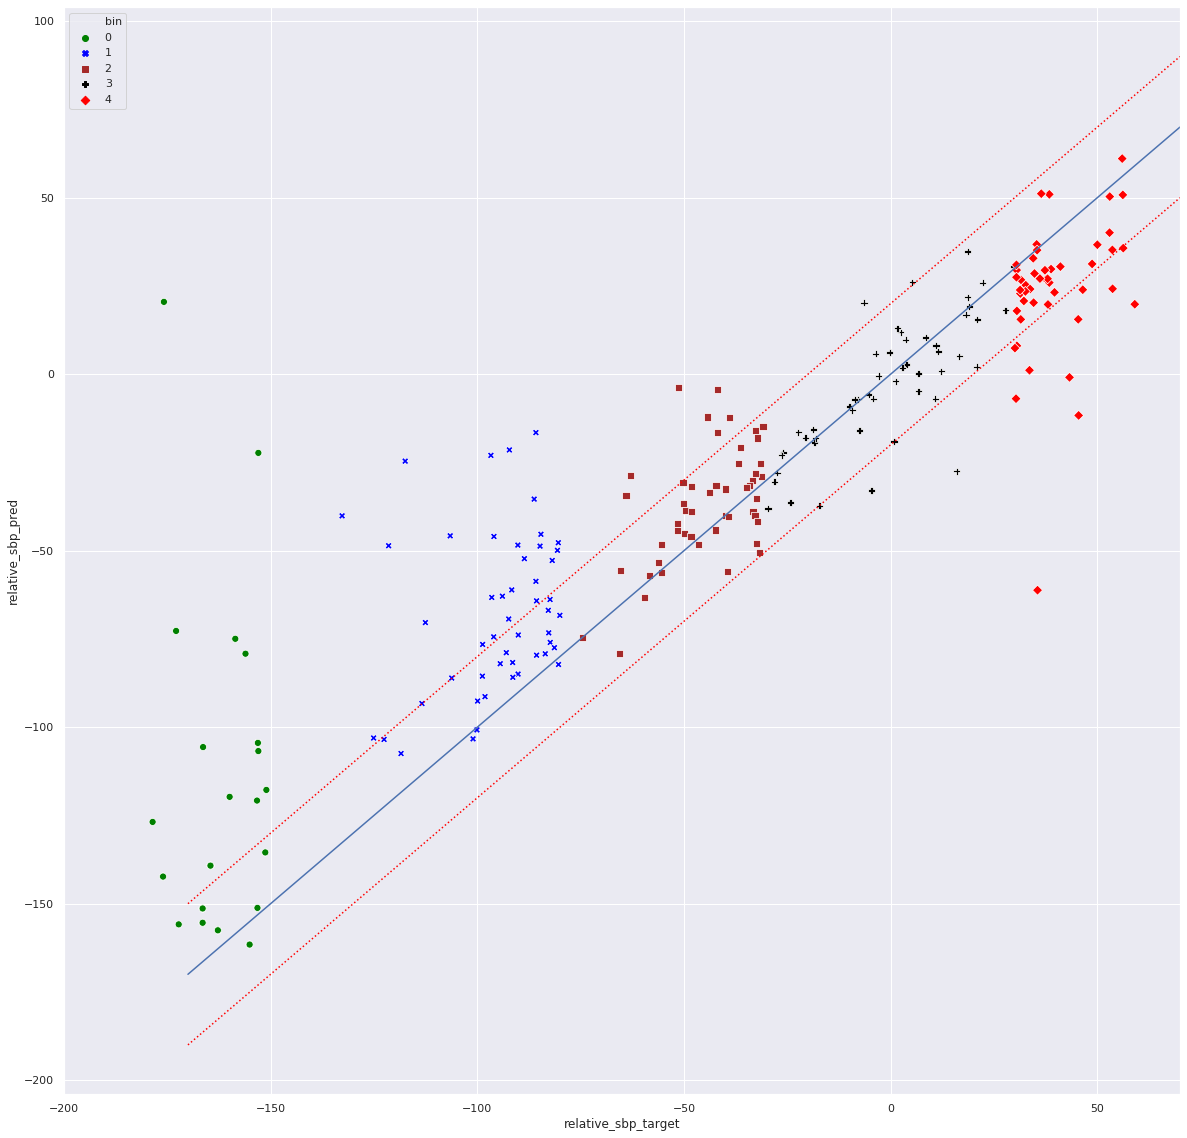

In [78]:
plt.figure(figsize=(20,20))
sns.scatterplot(x='relative_sbp_target', y='relative_sbp_pred',hue="bin", style='bin',s=50, data=sample,
               palette=['green','blue', 'brown','black','red'])
plt.xlim(-200,70)
plt.plot([-170,70],[-170,70])
plt.plot([-170,70],[-150,90], ':', c='red')
plt.plot([-170,70],[-190,50], ':', c='red')

In [47]:
import random
random_sample_idx = random.choices(range(len(reg_result)),k=5000)

In [48]:
random_sample = reg_result.iloc[random_sample_idx] 
random_sample['relative_sbp_pred'] = random_sample['relative_sbp_pred'].apply(lambda x: x * sbp_std)
random_sample['relative_sbp_target'] = random_sample['relative_sbp_target'].apply(lambda x: x * sbp_std)
random_sample['relative_dbp_pred'] = random_sample['relative_dbp_pred'].apply(lambda x: x * dbp_std)
random_sample['relative_dbp_target'] = random_sample['relative_dbp_target'].apply(lambda x: x * dbp_std)

/home/ky/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ky/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ky/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

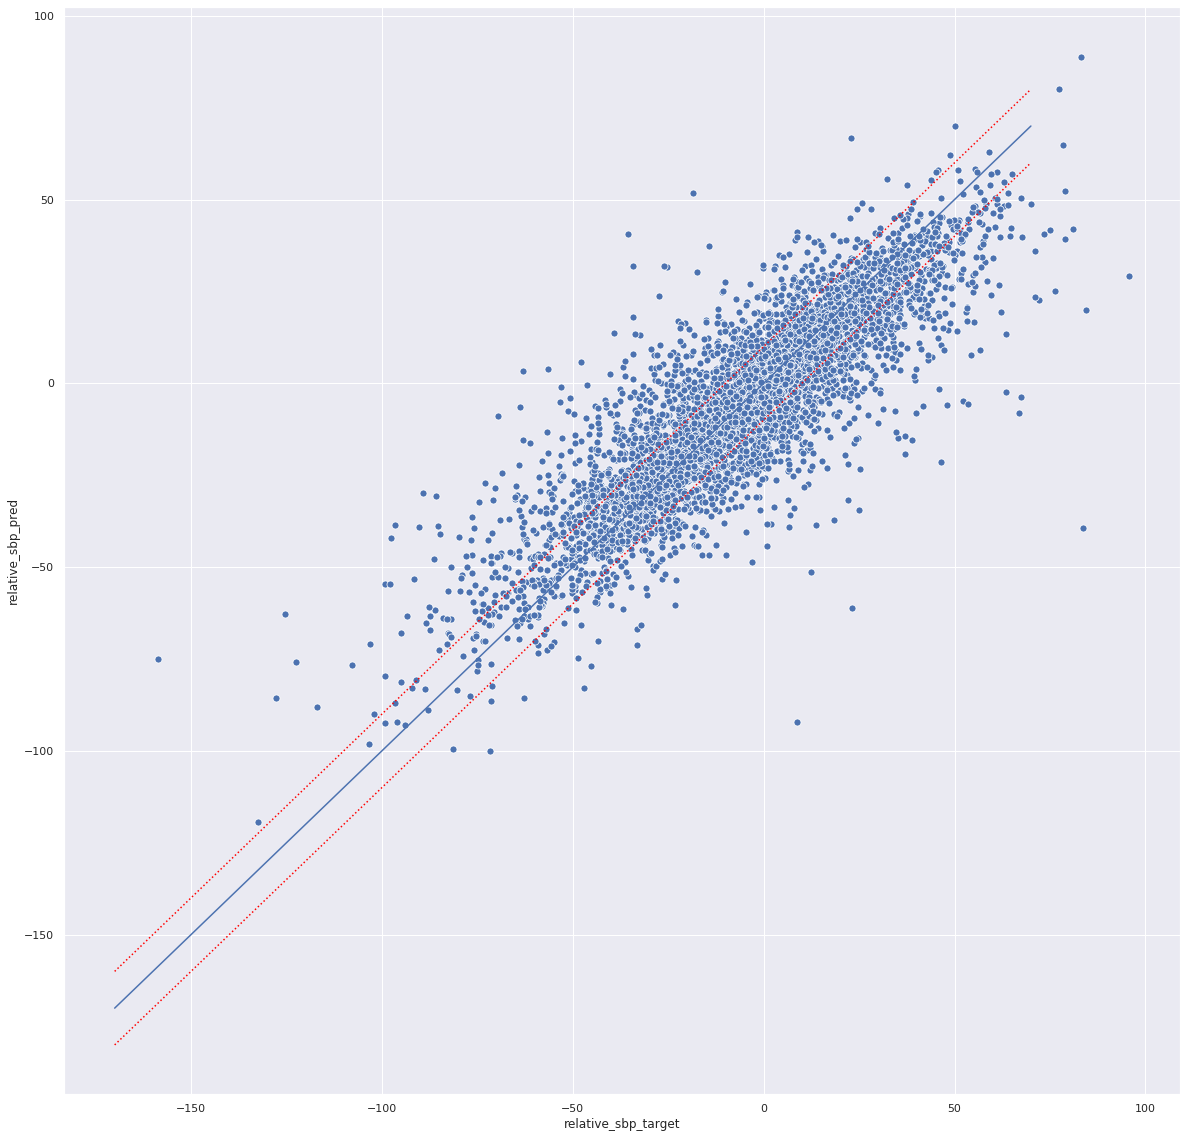

In [49]:
plt.figure(figsize=(20,20))
sns.scatterplot(x='relative_sbp_target', y='relative_sbp_pred',s=50, data=random_sample)
# plt.xlim(-150,70)
plt.plot([-170,70],[-170,70])
plt.plot([-170,70],[-160,80], ':', c='red')
plt.plot([-170,70],[-180,60], ':', c='red')

# Per hemo. frame visualization 

In [4]:
path ='raw_data/'
files = ['Hemodialysis1.csv','Hemodialysis2.csv']
df = pd.DataFrame()
for i in files:
    df = pd.concat((df, pd.read_csv(path+i)))

In [5]:
timeframe = pd.read_csv('MLP_timeframe.csv', header=None, index_col=0, names=['index','id'])

In [6]:
reg_result = pd.concat([reg_result, timeframe], axis=1)

In [13]:
%matplotlib qt5

In [14]:
import random

sample_num = 10
id_list = list(reg_result['id'].unique())
random_sample_idx = random.choices(range(len(id_list)),k=sample_num)
fig, axes = plt.subplots(1, sample_num) 
for i, ind in enumerate(random_sample_idx):
    sampled = reg_result.loc[reg_result['id'] == id_list[ind]]
    axes[i].plot(range(1, len(sampled)+1), sampled['sbp_pred'] * sbp_std + sbp_mean,  marker='o', label = 'prediction')
    axes[i].plot(range(1, len(sampled)+1), sampled['sbp_target'] * sbp_std + sbp_mean, marker='o', label= 'target')
plt.legend()

In [ ]:
len(sampled)

In [ ]:
reg_result.loc[reg_result['id'] == reg_result['id'].unique()[0]] 

## ROC Curve

In [98]:
cnt

86

In [59]:
import numpy as np
from sklearn.metrics import confusion_matrix, auc
import matplotlib.pyplot as plt

In [60]:
def roc_curve(label_type, thresholds):
    std = sbp_std if label_type =='sbp' else dbp_std 

    tpr = []
    fpr = []
    
    for theta in thresholds:
        cls_label = reg_result['relative_{}_target'.format(label_type)].apply(lambda x: 1 if abs(x * std) > theta else 0)
        cls_pred =reg_result['relative_{}_pred'.format(label_type)].apply(lambda x: 1 if abs(x * std) > theta else 0)
        confusion_mtx = confusion_matrix(cls_label,cls_pred)

        tp = confusion_mtx[1][1] 
        tn = confusion_mtx[0][0] 
        fp = confusion_mtx[0][1] 
        fn = confusion_mtx[1][0] 

        tpr.append(tp/(tp+fn))
        fpr.append(fp/(fp+tn))
    
    return tpr, fpr

In [61]:
thresholds = [0.5,0.9] + list(range(1,65,5))
tpr, fpr = roc_curve('sbp',thresholds)

In [79]:
%matplotlib qt
plt.plot(fpr,tpr)

plt.xlim(-0.000001,1)
plt.ylim(0,1)
plt.show()

for i in range(len(fpr)):
    if thresholds[i] == 1:
        plt.annotate(xy=(fpr[i]-0.05, tpr[i]), s=thresholds[i], fontsize=8)
    else:
        plt.annotate(xy=(fpr[i], tpr[i]), s=thresholds[i], fontsize=8)

In [63]:
auc(fpr,tpr)

0.7753022872895328